Suppose $I$ satisfies $\mathcal A(I) = b$, consider the SDPs
$$\max Tr(C^TX) \text{ s.t. } \mathcal A(X) = b,\;  X \succeq 0$$


$$\max \lambda_{\min}(X) \text{ s.t. } \mathcal A(X) = b, Tr(C^TX) = \gamma,$$

where $\gamma<Tr(C)$.

Define the map $Z(X) = I + \frac1{1-\lambda_{\min}(X)} (X - I)$.

$X_*$ is optimal to (1) iff $Z(X_*)$ is optimal to (2).


$$\mathcal C = \{ A(X) = b, Tr(C^TX) = \gamma\}$$
$$\mathcal C^T = \{ A(X) = b, Tr(C^TX) = 0\}$$

$$\mathcal P_{\mathcal C^T}(V) = \mathcal Z_0\left(V - \frac{\langle \mathcal Z_0(L_G),  \mathcal Z_0(L_G) \rangle}{\langle \mathcal Z_0(L_G),  \mathcal Z_0(V) \rangle} L_G\right) \text{ where } \mathcal Z_0(X) = X - diag(X)$$
$$\mathcal P_{\mathcal C}(X + V) = X + P_{\mathcal C^T}(V) \quad \forall X \in \mathcal C$$



Algorithm:

for $t = 1, \ldots,$

$X_{t+1} \leftarrow X_t+ \alpha_t  \mathcal P_{\mathcal C^T}\left( \frac{\partial f(X_t)}{\|\partial f(X_t)\|}\right)$


# For max-cut

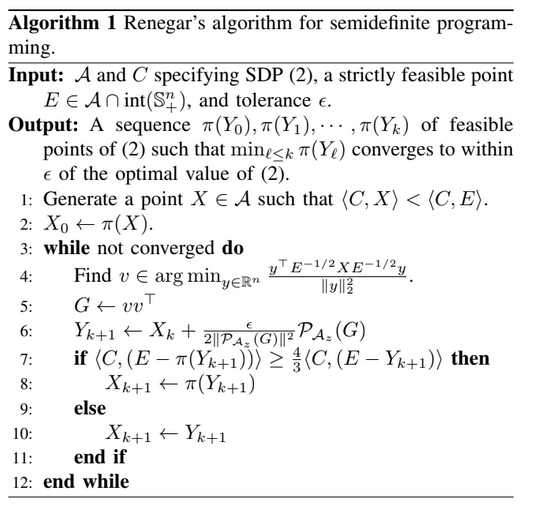

In [2]:
import time
import numpy as np
import picos as pic
import matplotlib.pyplot as plt
from scipy.io import mmread
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm, trange
import warnings
warnings.filterwarnings('ignore')

In [3]:
# generate random graph

# n = 3
# p = .5
# np.random.seed(3)
# A = (np.random.rand(n, n) > p).astype(float)
# for i in range(n): 
#     A[i, i] = 0
# for i in range(n): 
#     for j in range(i): 
#         A[i, j] = A[j, i]
A = mmread('graphs/hamming6-4.mtx')
n = A.shape[0]
print("n = {n}".format(n=n))
D = np.diag(np.sum(A, axis=int(0)))
L = (D - A)#.astype(float)
L = np.array(L)
L
C = L/4

n = 64


In [4]:
def optimize_over_elliptope(C):
    maxcut_problem = pic.Problem()
    # Variables
    X = pic.SymmetricVariable("X", shape=int(n))

    ## Objective
    maxcut_problem.set_objective('max', (C|X))

    ## Constraints
    # X psd
    maxcut_problem.add_constraint(X >> int(0))
    # 1 on the diagonal
    maxcut_problem.add_constraint(pic.maindiag(X) == int(1))

    maxcut_problem.solve()

    return maxcut_problem.value, np.array(X.value)

#np.random.seed(0)
#C = np.random.randn(3, 3)
optimize_over_elliptope(C)

(22175.999999472868, array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]))

In [5]:
def picos_solve_maxcut(L, solver, verbosity):
    maxcut_problem = pic.Problem()

    # Parameter
    L_param = pic.Constant("L", L, shape=(n, n))

    # Variables
    X = pic.SymmetricVariable("X", shape=int(n))


    ## Objective
    maxcut_problem.set_objective('max', float(1/4.) * (L|X))

    ## Constraints
    # X psd
    maxcut_problem.add_constraint(X >> int(0))
    # 1 on the diagonal
    maxcut_problem.add_constraint(pic.maindiag(X) == int(1))

    if verbosity:
        print(maxcut_problem)

    maxcut_problem.solve(solver=solver, verbosity=verbosity)
    return maxcut_problem.value

sdp_obj_value = picos_solve_maxcut(L, "mosek", 1)
print(sdp_obj_value)

------------------------------
Semidefinite Program
  maximize 0.25·⟨[64×64], X⟩
  over
    64×64 symmetric variable X
  subject to
    X ≽ 0
    maindiag(X) = [1]
------------------------------
            PICOS 2.0.8            
Problem type: Semidefinite Program.
Searching a solution strategy for MOSEK (Optimizer).
Solution strategy:
  1. ExtraOptions
  2. MOSEKSolver
Applying ExtraOptions.
Building a MOSEK (Optimizer) problem instance.
Starting solution search.
-----------------------------------
      MOSEK via Optimizer API      
-----------------------------------
Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 2144            
  Cones                  : 0               
  Scalar variables       : 2080            
  Matrix variables       : 1               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear

In [6]:
def generate_initial_point(A, b, C, gamma, solver=None, verbosity=False):
    linear_problem = pic.Problem()

    n = len(A[0])
    # Variables
    X = pic.SymmetricVariable("X", shape=int(n))

    ## Constraints
    linear_problem.add_constraint(C | X == gamma)
    for Ai, bi in zip(A, b):
        linear_problem.add_constraint(Ai | X == bi)

    linear_problem.set_objective('Min', pic.norm(X))
    if verbosity:
        print(linear_problem)

    linear_problem.solve(solver=solver, verbosity=verbosity)
    
    return np.array(X.value)



def project_l2(G, A, b, C, gamma, solver=None, verbosity=False):
    """
    Solves the least-squares problem
    min ||X - G|| s.t. A(X) = b, C.X = gamma
    """
    
    least_squares = pic.Problem()

    n = len(A[0])
    # Variables
    X = pic.SymmetricVariable("X", shape=int(n))

    # objective
    least_squares.set_objective('Min', pic.norm(X - G))
    
    ## Constraints
    least_squares.add_constraint(C | X == gamma)
    for Ai, bi in zip(A, b):
        least_squares.add_constraint(Ai | X == bi)

    if verbosity:
        print(least_squares)

    least_squares.solve(solver=solver, verbosity=verbosity)
    
    return np.array(X.value)


def min_lambda(A):
    return np.min(np.linalg.eigvalsh(A))
    

def min_eigenvec(A):
    vals, vecs = np.linalg.eig(A)
    idx = np.argmin(vals)
    min_eigenvec = vecs[:, idx]
    return min_eigenvec

def max_lambda(A):
    return min_lambda(-A)

def max_eigenvec(A):
    return min_eigenvec(-A)



def outer_product(u, v):
    assert len(u.shape) == 1
    assert len(v.shape) == 1
    return u[:, None] @ v[:, None].T


def dot_matrix(A, B):
    """ 
    Returns Tr(A @ B.T).
    """
    assert A.shape == B.shape
    return np.dot(A.flatten(), B.flatten())
    


In [7]:
def renegar_sdp_solver(A, C, b, E, eps, num_iters, X_history=None, pi_X_history=None, z_history=None, z0=None):
    """
    Solves the SDP max <C,X> s.t. Ai.X = bi using Renegar's first orderr method.
    Args:
    A: mxnxn tensor: List of matrices Ai
    b: mx1 vector of the same size as A
    C: nxn matrix. The objective function
    E: nxn matrix. A strictly feasible solution
    eps: redisred (relative) tolerance
    """
    
    # projects X to the boundary
    pi = lambda X: E + (X-E)/ (1-min_lambda(X))
    
    E_sqrt = sqrtm(E)
    
    # generate X s.t. A(X) = b and <C,X> = z
    z = z0
        
    X = generate_initial_point(A, b, C, z,)
    X0 = pi(X)
    z = dot_matrix(C, X0)
    print("C|X0", z)
    print("C|I", dot_matrix(C, E))

    X_current = X0
    X_next = None
    loading_bar = tqdm(total=num_iters)
    for k in range(num_iters):
        

        # compute subgradient
        v = min_eigenvec(E_sqrt @ X_current @ E_sqrt)
        G = outer_product(v, v)
        
        # project subgradient
        proj_G = project_l2(G, A, 0*b, C, 0*z,)
    
        # gradient update
        norm_proj_G = np.linalg.norm(proj_G)
        #print(v)
        Y_next = X_current + eps / (2*norm_proj_G**2) * proj_G
        #print(k, min_lambda(Y_next))
        
        pi_Y_next = pi(Y_next)

        #level set update
        if dot_matrix(C, E-pi_Y_next) >= 4/3. * dot_matrix(C, E - Y_next):
            X_next = pi_Y_next
            z = dot_matrix(C, pi_Y_next)
        else:
            X_next = Y_next
        #X_next = pi_Y_next
    
        X_current = X_next
        loading_bar.update(int(1))
        loading_bar.set_description("obj({obj:.3g}) | z({z:.3g}) | eps({eps:.2g})".format(
            obj=dot_matrix(C, pi_Y_next), 
            z=z,
            eps=eps))

        # save X_current
        if X_history != None:
            pi_X_history.append(pi_Y_next)
            X_history.append(Y_next)
            z_history.append(z)
            
    return X_next


C|X0 -5.419354838709664
C|I -352.0


Text(0.5,1,'Objective value')

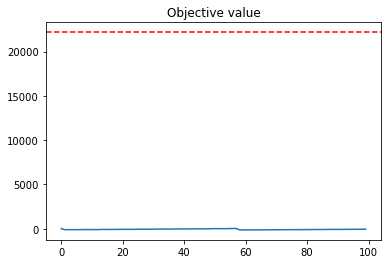

In [20]:
canonical_basis = np.eye(n)
A = np.array([ei[:,None] @  ei[None, :] for ei in canonical_basis])
b = np.ones(n)
E = np.eye(n)

eps = float(.1)
pi_X_history = []
X_history = []
z_history = []
renegar_sdp_solver(A, -C, b, E, eps, num_iters=int(100), 
                   X_history=X_history, pi_X_history=pi_X_history, z_history=z_history, z0=float(10000))



obj_history = np.array([dot_matrix(Xi, C) for Xi in pi_X_history])


#plt.yscale('log')
plt.plot(-obj_history)
plt.axhline(y=sdp_obj_value, ls='--', c='r')
plt.title("Objective value")


[[ 1.76405235  1.3205252   0.9644132 ]
 [ 1.3205252   1.86755799 -0.56431754]
 [ 0.9644132  -0.56431754 -0.10321885]]
opt value 2.17012041021273
C|X0 -0.7380516885137878
C|I 3.5283914843240733


Text(0.5,1,'min eigen value of X')

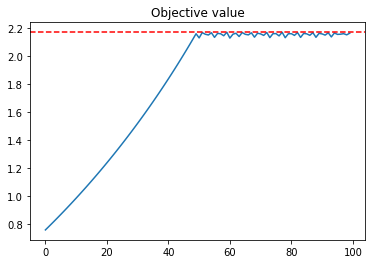

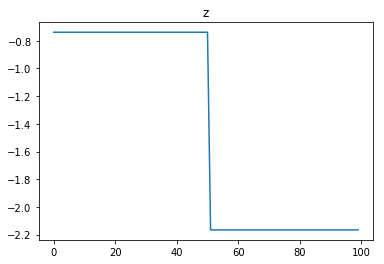

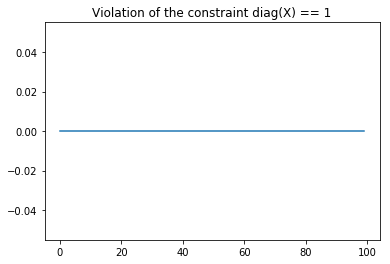

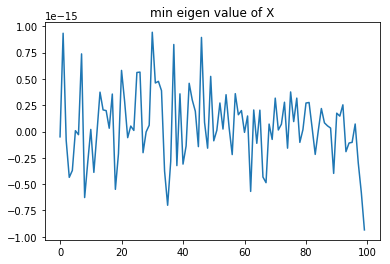

In [366]:
# max cut

# Setup SDP for max cut problem
n = m = len(L)
C = -L/4


np.random.seed(0)
n = m = 3
C = np.random.randn(3,3)
C = (C+C.T)/2
print(C)
canonical_basis = np.eye(n)
A = np.array([ei[:,None] @  ei[None, :] for ei in canonical_basis])
b = np.ones(m)
E = np.eye(n)

sdp_obj_value, sdp_opt_sol = optimize_over_elliptope(-C)
print("opt value", sdp_obj_value)

eps = float(1e-2)
pi_X_history = []
X_history = []
z_history = []
renegar_sdp_solver(A, C, b, E, eps, num_iters=int(100), 
                   X_history=X_history, pi_X_history=pi_X_history, z_history=z_history, z0=float(-1000))



obj_history = np.array([dot_matrix(Xi, C) for Xi in pi_X_history])


#plt.yscale('log')
plt.plot(-obj_history)
plt.axhline(y=sdp_obj_value, ls='--', c='r')
#plt.ylim(0, sdp_obj_value*1.1)
plt.title("Objective value")


plt.figure()
plt.plot(z_history)
plt.title("z")


plt.figure()
plt.plot([np.linalg.norm(np.diag(Xi)-1) for Xi in pi_X_history])
plt.title("Violation of the constraint diag(X) == 1")

plt.figure()
plt.plot([min_lambda(Xi) for Xi in pi_X_history])
plt.title("min eigen value of X")

In [367]:
import json

export_data = {}
export_data['pi_X'] = [(Xi[0,1], Xi[0, 2], Xi[1, 2]) for Xi in pi_X_history]
export_data['X'] = [(Xi[0,1], Xi[0, 2], Xi[1, 2]) for Xi in X_history]
export_data['c'] = [(C[0,1], C[0,2], C[1, 2])]
export_data['opt_X'] = [(sdp_opt_sol[0,1], sdp_opt_sol[0,2], sdp_opt_sol[1, 2])]
export_data['opt_value'] = sdp_obj_value

export_data['trace_C'] = C.trace()

export_data['z'] = z_history
json.dump(export_data, open('renegar_output.json', 'w'))

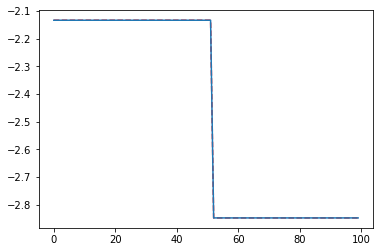

In [368]:
plt.plot( np.array(export_data['X']) @ np.array(export_data['c']).T, 'r--')
plt.plot([ (dot_matrix(Xi, C)-C.trace())/2 for Xi in X_history])
#plt.plot([np.dot((Xi[0,1], Xi[0, 2], Xi[1, 2]), (C[0,1], C[0,2], C[1, 2]) ) for Xi in X_history])


In [365]:
X_history[0]
C

array([[ 1.76405235,  0.40015721,  0.97873798],
       [ 2.2408932 ,  1.86755799, -0.97727788],
       [ 0.95008842, -0.15135721, -0.10321885]])